In [12]:
from sklearn.model_selection import train_test_split
# !pip install pkbar
import pkbar
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader,Sampler,BatchSampler,SubsetRandomSampler
import torch.nn.utils.rnn as rnn_utils
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np
import pandas as pd

import random
import math
import time
import re
from collections import defaultdict, Counter
import pickle
import gc
import io

# !pip install Bio
# !pip install Bio.seq
# from Bio.Seq import Seq 
# from Bio import pairwise2
# from Bio.pairwise2 import format_alignment 
from multiprocessing import Pool
import multiprocessing

In [2]:
device = (
	'cuda'
	if torch.cuda.is_available()
	else 'mps' 
	if torch.backends.mps.is_available()
	else 'cpu')
print(device)

mps


### 随机种子 ###

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

torch.set_printoptions(precision=6,sci_mode=False)
pd.set_option('display.float_format',lambda x : '%.6f' % x)

### 类的定义 ###

In [4]:
class SubsetRandomSampler(Sampler):
    def __init__(self, lst_inds):
        self.lst_idx = lst_inds

    def __iter__(self):
        idx = [self.lst_idx[i] for i in torch.randperm(len(self.lst_idx))]
        return iter(idx)

    def __len__(self):
        return len(self.indices)

class BatchSampler(Sampler):
    def __init__(self,gRNAs, grp):
        lst_idx = []
        for gRNA in gRNAs:
            lst_idx.append(grp[gRNA].index.values)
        sampler = SubsetRandomSampler(lst_idx)
        self.sampler = sampler
        self.batch_size = len(grp[gRNA])
    def __iter__(self):
        for idx in self.sampler:
            self.batch_size = len(idx)
            yield idx

    def __len__(self):
        return self.batch_size    # batch size就是每个batch的样本个数
    
    
class gRNADataset(Dataset):
    def __init__(self,datafrm):
        self.df = datafrm.reset_index(drop=True)
        self.df.columns = ['index','offset', 'y','eff','is_edit','wgt']
        self.indexes = list(self.df['index'].values)
        self.offsets = list(self.df['offset'].values)
        self.y = list(self.df['y'].values)
        self.eff = list(self.df['eff'].values)
        self.is_edit = list(self.df['is_edit'].values)
        self.wgt = list(self.df['wgt'].values)
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        indexes = self.indexes[idx]
        offsets = self.offsets[idx]
        y = self.y[idx]
        eff = self.eff[idx]
        is_edit = self.is_edit[idx]
        wgt = self.wgt[idx]
        return indexes, offsets, y, eff, is_edit, wgt
    

### 定义函数 ###

In [5]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

stoi = {'<pad>':0, 'a':1, 'c':2, 'g':3, 't':4, '-':5, 'A':1, 'C':2, 'G':3, 'T':4,'B':5,'D':6}
itos = {0: '<pad>', 1:'a',  2 :'c', 3:'g',0: 't', 1:'A',  2 :'C', 3:'G',4:'T',5:'B',6:'D'}

def get_encoding(row, is_pred=False):
    seq1 = row['gRNA']
    seq2 = row['target']
    is_edit = row['is_edit']
    y = None
    wgt = None
    eff = row['efficiency']
    if not is_pred:
        y = row['efficiency'] # 未计算，输入值没有
        wgt = row['count']
    seq_idx = []
    for i,(nuc1, nuc2) in enumerate(zip(seq1,seq2)):
        seq_idx += [stoi[nuc1]] + [stoi[nuc2]]
    offset = [i for i in range(0,len(seq_idx),2)] # range(start, stop, step)
    r = (seq_idx, offset, y, eff, is_edit, wgt) if not is_pred else (seq_idx, offset, is_edit)
    return r


### ----- offtarget编码方式 ------- ###

# def get_encoding(row, is_pred=False):
#     '''Sequence encoding.'''
#     gRNA = row['gRNA']
#     target = row['target']
#     aln = pairwise2.align.globalms(gRNA, target, 1, -1, -3, -2)
#     src, _aln, tgt = format_alignment(*aln[0]).split('\n')[:-2]
#     encode_dict = {'<pad>':0, 'A': 1, 'C': 2, 'G':3, 'T': 4, '-': 5}
#     seq1 = [encode_dict[nuc] for nuc in src]
#     seq2 = [encode_dict[nuc] for nuc in tgt]
#     is_edit = row['is_edit']
#     y = None
#     wgt = None
#     eff = row['overall_efficiency']
#     if not is_pred:
#         y = row['proportion']
#         wgt = row['count']
#     r = (seq1, seq2, y, eff, is_edit, wgt) if not is_pred else (seq1, seq2, is_edit)
#     return r

def generate_batch(batch):
    global debug_batch
    indexes = []
    offsets = []
    ys = []
    effs = []
    seq_len = []
    edit_status = []
    wgts = []
    old_max_ofs = 0
    debug_batch = batch
    for i,( idx, ofs, y, eff, is_edit, wgt ) in enumerate(batch):
        indexes += idx
        i = 1 if i > 0 else 0
        offset = old_max_ofs + np.array(ofs) + i * 2 # 转换为从2开始，step为2的数组
        old_max_ofs = offset[-1] # 最后一位数
        offsets += list(offset)
        ys.append(y)
        effs.append(eff)
        seq_len.append(len(ofs))
        edit_status.append(is_edit)
        wgts.append(wgt)
        
    a = indexes
    b = offsets
    c = ys #
    d = effs
    e = seq_len
    f = edit_status.index(0.) #non_id
    g = wgts
    return a,b,c,d,e,[f],g

### 定义模型 ###

In [6]:

seq_len = 20
class BiLSTM_Attention(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, dropout=0.5):
        super(BiLSTM_Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.EmbeddingBag(vocab_size, embedding_dim)
        
        '''    
        
        torch.nn.EmbeddingBag(num_embeddings, embedding_dim, max_norm=None, norm_type=2.0, scale_grad_by_freq=False, mode='mean', sparse=False, _weight=None, include_last_offset=False, padding_idx=None, device=None, dtype=None)
        '''

        self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers,
                           bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(dropout)  

    def attention_net(self, x, query, mask=None): 
        
        d_k = query.size(-1)   
        scores = torch.matmul(query, x.transpose(1, 2)) / math.sqrt(d_k)  
        alpha_n = F.softmax(scores, dim=-1) 
        context = torch.matmul(alpha_n, x).sum(1)
        
        return context, alpha_n
    
    def forward(self, seq, offset, length):
        global debug_var
        batch_size = len(length)
        emb = self.dropout(self.embedding(seq, offset))
        emb_v = emb.view(batch_size,seq_len, -1)
        emb_vt = emb_v.transpose(1,0)
        out, (hidden, _) = self.rnn(emb_vt)
        out = out.permute(1, 0, 2)  
        query = self.dropout(out)
        attn_output, alpha_n = self.attention_net(out, query)
        
        logit = F.leaky_relu(self.fc(attn_output))
        
        return logit

初始化权重

In [7]:
def init_weights(m):

    for name, param in m.named_parameters():
        if 'rnn.weight_' in name:
            nn.init.orthogonal_(param.data)
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

超参数设置

In [8]:
ENC_INPUT_DIM = 6
ENC_EMB_DIM = 64 
ENC_HID_DIM = 128

'''
embedding dimension: 64
hidden dimension: 128
'''


N_LAYERS = 1
ENC_DROPOUT = 0.5

In [9]:
model = BiLSTM_Attention(ENC_INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)

### 设置损失函数 ###

In [10]:
criterion_prop = nn.KLDivLoss(reduction='none')
criterion_mse = nn.MSELoss(reduction='none')

N_EPOCHS = 250

CLIP = 1

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
best_valid_loss = float('inf')

### 训练模型 ###

载入权重

In [11]:
model.apply(init_weights)

载入数据

In [ ]:
df_info = pd.read_csv('./HEK293T_ABE.csv')
df_info[df_info['all_count']>=100]
df = df_info[['gRNA','target','count','efficiency']]
df['is_edit'] = pd.Series(dtype=int)

for i in range(len(df)):
    if df['gRNA'][i] == df['target'][i]:
        df.loc[i, 'is_edit'] = 0
    else:
        df.loc[i, 'is_edit'] = 1
df['is_edit'] = df['is_edit'].astype(int)

grouped = df.groupby('gRNA')
new_rows = []

for name, group in grouped:

    if group['is_edit'].all():

        new_row = {
            'gRNA': group.iloc[0]['gRNA'],  
            'target': group.iloc[0]['gRNA'], 
            'count': 0,
            'efficiency': 0.0,
            # 'proportion': 0.0,
            'is_edit': 0
        }
        new_rows.append(new_row)

df = pd.concat([pd.DataFrame(new_rows), df], ignore_index=True)

df[['index','offset','y','eff','is_edit','wgt']] = df.apply( lambda x:pd.Series(get_encoding(x,is_pred=False)),axis=1)

df = df[['gRNA','target','index','offset','y','eff','is_edit','wgt']]
# print(df.head())

grp_df = dict(list(df.groupby('gRNA')))
df_dataset = gRNADataset(df[['index','offset','y','eff','is_edit','wgt']] )
# df[df.is_edit == 0][['gRNA','eff']].to_pickle('test_10000.pkl')
list_gRNA = df.gRNA.unique()

train_data, test_data = train_test_split(list_gRNA, test_size=0.05, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.05, random_state=42)

train_iter = DataLoader(df_dataset, batch_sampler=BatchSampler(train_data, grp_df), collate_fn = generate_batch)
val_iter = DataLoader(df_dataset, batch_sampler=BatchSampler(val_data, grp_df), collate_fn=generate_batch)
test_iter = DataLoader(df_dataset, batch_sampler=BatchSampler(test_data, grp_df), collate_fn=generate_batch)

train and validate the model

In [ ]:
all_losses = []
val_all_losses =[]

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_per_epoch = len(train_data)
    kbar = pkbar.Kbar(target=train_per_epoch, epoch=epoch, num_epochs=N_EPOCHS, width=8, always_stateful=False)

    
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(train_iter):
        index = torch.LongTensor(batch[0]).to(device)
        offset = torch.LongTensor(batch[1]).to(device)
        y = torch.FloatTensor(batch[2]).to(device)
        # eff = torch.FloatTensor(batch[3]).to(device)[0].view(-1)
        length = torch.LongTensor(batch[4]).to(device)
        non_id = torch.LongTensor(batch[5]).to(device)
        wgt = torch.FloatTensor(batch[6]).to(device) + 1
        y_sm = wgt/wgt.sum()

        
        optimizer.zero_grad()
        outputs = model( index, offset, length )
        outs = outputs.view(-1)
        
        y_hat_ls = F.log_softmax(outs,0)
        loss_temp = criterion_prop( y_hat_ls, y_sm )
        loss1 = torch.abs( loss_temp * wgt ).mean()
        # print(loss1)

        y_hat_sm = F.softmax(outs,0)
        loss_temp =  criterion_mse( y_hat_sm, y )
        loss2 = ( loss_temp * wgt ).mean()    
        # print(loss2)    
        loss3 = criterion_mse( 1 - y_hat_sm[non_id].view(-1), 1-y[non_id].view(-1) )*100        
        loss = 3/6 * loss1 + 1/6 * loss2 + 2/6 * loss3       
        # print(loss)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)        
        optimizer.step()
        epoch_loss += loss.item()
        mean_loss = epoch_loss / (i + 1)
        kbar.update(i, values=[("loss", epoch_loss / (i + 1)),("loss1",loss1),("loss2",loss2)])
        
    all_losses.append(mean_loss)
          
    model.eval()
    epoch_loss = 0
    
    ### -------------- validation ------------ ##
    with torch.no_grad():

        for i, batch in enumerate(val_iter):

            index = torch.LongTensor(batch[0]).to(device)
            offset = torch.LongTensor(batch[1]).to(device)
            # y = torch.FloatTensor(batch[2]).to(device)
            # eff = torch.FloatTensor(batch[3]).to(device)
            length = torch.LongTensor(batch[4]).to(device)
            non_id = torch.LongTensor(batch[5]).to(device)
            wgt = torch.FloatTensor(batch[6]).to(device) + 1
            y_sm = wgt/wgt.sum()

            optimizer.zero_grad()
            outputs = model(index, offset, length)

            outs = outputs.view(-1)
            y_hat_ls = F.log_softmax(outs,0)
            y_sm = (y.view(-1) + 1e-6)/(1 + 1e-6)
            loss_temp = criterion_prop( y_hat_ls, y_sm )
            loss1 = torch.abs(loss_temp).mean()*100

            y_hat_sm = F.softmax(outs,0)
            loss2 = (criterion_mse( y_hat_sm, y )).mean()*100
            loss = (loss1 + loss2).mean()
            epoch_loss += loss.item()
        
        valid_loss = epoch_loss / len( val_data )
        val_all_losses.append(valid_loss)
    print(f"Epoch {epoch+1}/{N_EPOCHS}, Valid Loss: {valid_loss:.3f}")       
    kbar.add(1, values=[("val_loss", valid_loss)])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.show()

In [ ]:
plt.plot(val_all_losses)
plt.show()

### **Test the model on test data** ###

In [ ]:
model.eval()
epoch_loss = 0
with torch.no_grad(): 
    for i, batch in enumerate(test_iter):
        seq1 = torch.LongTensor(batch[0]).to(device)
        seq2 = torch.LongTensor(batch[1]).to(device)
        # y = torch.FloatTensor(batch[2]).to(device)
        # eff = torch.FloatTensor(batch[3]).to(device)
        length = torch.LongTensor(batch[4]).to(device)
        non_id = torch.LongTensor(batch[5]).to(device)
        wgt = torch.FloatTensor(batch[6]).to(device) + 1
        y_sm = wgt/wgt.sum()
        
        outputs = model(seq1, seq2, length)

        outs = outputs.view(-1)
        y_hat_ls = F.log_softmax(outs, 0)
        y_sm = (y.view(-1) + 1e-6) / (1 + 1e-6)
        loss_temp = criterion_prop(y_hat_ls, y_sm)
        loss1 = torch.abs(loss_temp).mean() * 100

        y_hat_sm = F.softmax(outs, 0)
        loss2 = (criterion_mse(y_hat_sm, y)).mean() * 100
        loss = (loss1 + loss2).mean()
        epoch_loss += loss.item()

    test_loss = epoch_loss / len(test_data)
print(f"Epoch {epoch+1}/{N_EPOCHS}, Test Loss: {test_loss:.3f}")       
kbar.add(1, values=[("val_loss", test_loss)])

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_true_list = []
y_score_list = []

model.eval()
with torch.no_grad():
    for i, batch in enumerate(test_iter):
        seq1 = torch.LongTensor(batch[0]).to(device)
        seq2 = torch.LongTensor(batch[1]).to(device)
        # y = torch.FloatTensor(batch[2]).to(device)
        wgt = torch.FloatTensor(batch[6]).to(device) + 1
        y_sm = wgt/wgt.sum()
        length = torch.LongTensor(batch[4]).to(device)

        outputs = model(seq1, seq2, length)

        y_hat_sm = F.softmax(outputs, 1)
        y_score_list.extend(y_hat_sm[:, 0].cpu().numpy()) 
        y_true_list.extend(y_sm.cpu().numpy())

threshold = 0.5
y_binary = np.where(np.array(y_true_list) > threshold, 1, 0)

fpr, tpr, _ = roc_curve(y_binary, y_score_list)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [9]:
a = [53.94195846769545, 56.44027533298068, 54.583650535089, 53.40881484935902, 53.728374311235214, 54.594259469597425, 53.0678776223218, 53.6191561088562, 53.156822456748394, 54.96110948513172, 53.094985407228826, 55.78290013807791, 53.350388247631216, 53.87698803188183, 52.96285012428849, 56.993566073664915, 51.366101814199375, 53.13543738676, 53.75795509507921, 55.72160844647443, 53.19379184729964, 53.610034371905854, 52.350338138085824, 54.388515055974324, 56.26947623182226, 53.595312319720236, 54.40584419536591, 53.6650943964499, 54.955643355616814, 54.0123763827218, 53.46340530084681]

b = list(range(1,32))

c =[24.401581976437072, 24.086247294944616, 24.07330168628276, 23.9648464688211, 23.910901358171852, 24.066727352996768, 24.10169506374793, 23.995325003995372, 23.971360235812917, 24.015223598621077, 24.041423812606187, 24.13841803199809, 24.0578319612302, 24.02343744838055, 24.054527770796717, 24.161044667855773, 24.045131112194245, 24.08523252924896, 24.099815267596647, 24.063983322725523, 24.059919394789862, 24.006143518391447, 24.082411417751633, 24.0740749502038, 24.025298213044884, 24.091821474210864, 24.203313676699796, 24.07343209221783, 24.050751346900668, 24.096575530691133, 24.18724471151376]

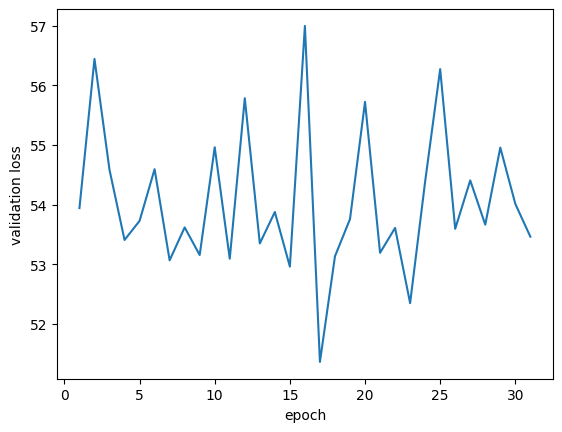

In [11]:
import matplotlib.pyplot as plt
plt.plot(b,a)
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.show()


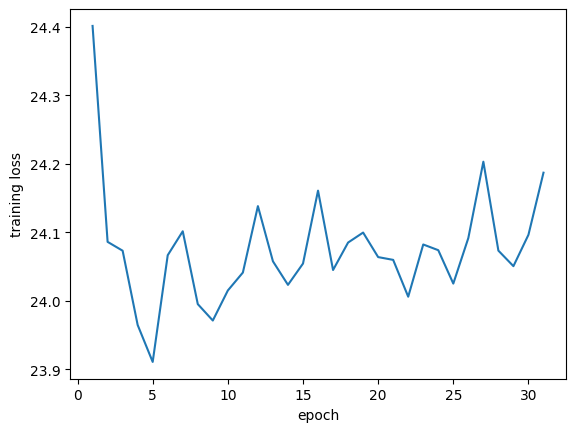

In [10]:
plt.plot(b,c)
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()


In [ ]:
All losses [23.04229225307657, 22.874528497133188, 23.730214337536072, 24.05045871914413, 23.967129894301742, 23.51214381459455, 23.6344966854437, 23.712117061935373, 23.556983431667252, 23.07039254537362, 23.40668521971578, 23.492791383521684, 23.770346900508613, 23.505502189818543, 23.69495936156304, 23.669771335803418]
Validation loss, [19.5393004742263, 19.390232057700775, 20.89923863863853, 20.939614894831404, 20.371333895740182, 19.827776185242303, 24.171227759004612, 20.210788097376028, 19.675720256913014, 20.950820883642557, 20.117232680842367, 19.62156253234595, 22.05868365946405, 21.482145130853826, 20.437605842926224, 19.05534805108814]

In [3]:
All_losses = [28.801609827941725, 24.214456956447922, 22.323259351150707, 21.744207441928566, 21.239932381141788, 20.233475291454077, 18.933991006222193, 17.781267414070573, 16.947224503378234, 15.92660414894089, 15.178722524250341, 14.493456974579965, 14.05313498761883, 13.571532266223684, 13.1999257329555, 12.76771449988831]
Validation_loss = [20.140536699296263, 19.37286134221338, 19.211421359317374, 18.181508226039774, 17.211998629637492, 16.715532593516027, 15.031272754521146, 15.200302634985906, 15.648109705961808, 12.872348237373021, 12.580695843072352, 12.695984754432374, 11.667026729593564, 12.145845969067805, 11.349968859063958, 11.686688676321621]

In [1]:
import matplotlib.pyplot as plt
randint = list(range(0,16))

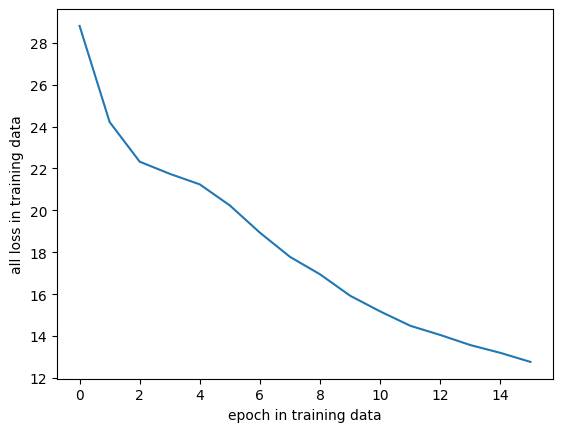

In [5]:
plt.plot(randint,All_losses)
plt.xlabel('epoch in training data')
plt.ylabel('all loss in training data')
plt.show()

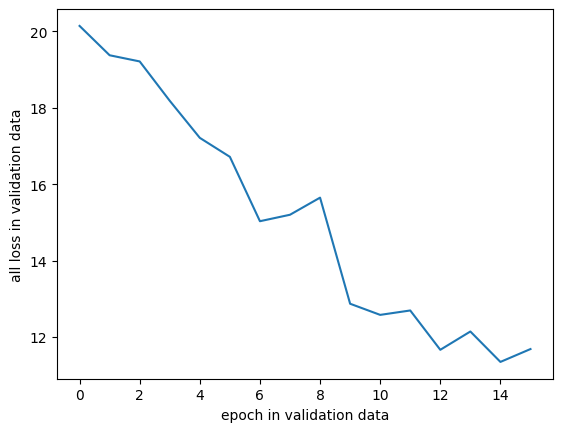

In [6]:
plt.plot(randint,Validation_loss)
plt.xlabel('epoch in validation data')
plt.ylabel('all loss in validation data')
plt.show()